![Titanic](https://upload.wikimedia.org/wikipedia/commons/3/38/RMS_Titanic_4.jpg)

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell"

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, HiveContext
import py4j

# conf = SparkConf().setAppName("SparkJupyterTitanic") \
#         .setMaster("local[2]") 
conf = SparkConf().setAppName("SparkJupyterTitanic") \
        .setMaster("yarn-client") \
        .set("spark.executor.memory", "512m") \
        .set("spark.executor.cores", 1) \
        .set("spark.executor.instances", 2)
sc = SparkContext(conf=conf)

try:
    # Try to access HiveConf, it will raise exception if Hive is not added
    sc._jvm.org.apache.hadoop.hive.conf.HiveConf()
    sqlContext = HiveContext(sc)
except py4j.protocol.Py4JError:
    sqlContext = SQLContext(sc)
except TypeError:
    sqlContext = SQLContext(sc)
sc

In [2]:
csv = "s3n://ltsai/smu-talk-8mar2016/titanic3.csv"

[Dataset Information](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)

In [3]:
from pyspark.sql.types import *
customSchema = StructType([StructField('pclass', StringType(), True),
                           StructField('survived', IntegerType(), True),
                           StructField('name', StringType(), True),
                           StructField('sex', StringType(), True),
                           StructField('age', StringType(), True),
                           StructField('sibsp', IntegerType(), True),
                           StructField('parch', IntegerType(), True),
                           StructField('ticket', StringType(), True),
                           StructField('fare', FloatType(), True),
                           StructField('cabin', StringType(), True),
                           StructField('embarked', StringType(), True),
                           StructField('boat', StringType(), True),
                           StructField('body', StringType(), True),
                           StructField('home.dest', StringType(), True)])
df = sqlContext.read.format('com.databricks.spark.csv'). \
        options(header='true', treatEmptyValuesAsNulls='true'). \
        load(csv, schema = customSchema)
df.registerTempTable("passengers")
sqlContext.cacheTable("passengers") 
df.count()

1309

In [4]:
df.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: float (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: string (nullable = true)
 |-- home.dest: string (nullable = true)



In [5]:
sqlContext.sql("select mean(age)from passengers").collect()

[Row(_c0=29.881137667304014)]

In [6]:
%matplotlib inline

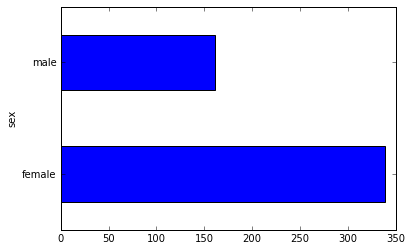

In [7]:
survival = sqlContext.sql("select sex, count(survived) as cnt from passengers where survived=1 group by sex").toPandas()
survival.plot(kind='barh', x='sex', y='cnt', legend=False)

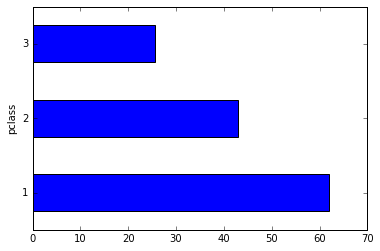

In [8]:
survival = sqlContext.sql(
    "select pclass, 100*(SUM(CASE WHEN survived = 1 THEN 1 ELSE 0 END)/count(*)) survival_rate \
     from passengers \
     group by pclass").toPandas()
survival.plot(kind='barh', x='pclass', y='survival_rate', legend=False)

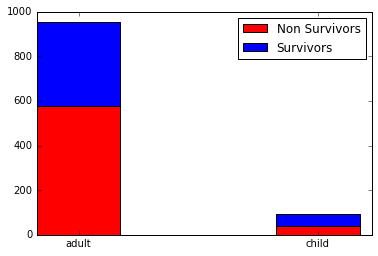

In [9]:
survival = sqlContext.sql("""SELECT 
                            (CASE 
                                 WHEN age <= 12 THEN 'child' 
                                 WHEN age > 12 THEN 'adult' 
                             END) age_group,
                             survived                           
                           from passengers 
                           where age is not null""")
survivors = survival.where(survival.survived==1).groupBy("age_group").count().toPandas()
non_survivors = survival.where(survival.survived==0).groupBy("age_group").count().toPandas()

import matplotlib.pyplot as plt
import numpy as np

ind = np.arange(2)
width = 0.35    

p1 = plt.bar(ind, non_survivors['count'], width, color = 'r')
p2 = plt.bar(ind, survivors['count'], width, color = 'b', bottom=non_survivors['count'])
plt.xticks(ind + width/2., survivors['age_group'])
plt.legend((p1[0], p2[0]), ('Non Survivors', 'Survivors'))

plt.show()

In [10]:
sc.stop()

[Sample Tableau dashboard](https://public.tableau.com/views/TitanicDashboards/SurvivalontheTitanicbyAgeGenderClassFare?:embed=y&:display_count=yes&:showTabs=y)